## Compute my own drag coefficient from SAR data

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_GET_OWN_C/',
}

PRMS = {
    'sav_fgs': True,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

640


In [4]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 1) Compute Cd from all SAR data

In [5]:
### Hyperparameters
rs = np.linspace(1000, 5e5, 500)

In [14]:
# Prepare new_dsg
listOfDatasets  = []

for t in tqdm(range(len(dsg_filtered.time))):
    # Open
    ds  = dsg_filtered.isel(time=t)

    # Determined parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)
    
    # Holland
    V    = holland_profile(rs, lat, B, vmn, rmx, vmx)

    # Get own Cd
    cd             = np.ones_like(V) * 1e-3

    try:
        # For r > R+
        cd[V <= 10.92] = 1.2e-3 # We use 10.92 instead of 11 to ensure continuity of Cd
        outer          = (V > 10.92) & (rs >= float(ds.rps))
        cd[outer]      = (0.49 + 0.065 * V[outer]) * 1e-3
        # For Rmax < r < R+
        cdps           = cd[rs >= float(ds.rps)][0]
        near           = (rs <= float(ds.rps)) & (rs >= float(ds.rmx))
        cd[near]       = cdps * rs[rs >= float(ds.rps)][0] * V[rs >= float(ds.rps)][0] ** 2 / (rs[near] * V[near] ** 2)

        # Average
        cd_mean = cd[(rs >= float(ds.rmx)) & (rs <= float(ds.r0))].mean()
        # print('Avg Cd = {:.2f}e-3'.format(cd_mean * 1e3))

        if PRMS['sav_fgs']:
            plt.plot(rs / 1000, cd * 1e3)
            plt.axvline(ds.rmx / 1000, c='k', linewidth=3)
            plt.axvline(ds.rps / 1000, c='k')
            plt.axvline(ds.r0  / 1000, c='k', linestyle='dashed')
            plt.xlim(0, 250)
            plt.xlabel(r'Distance from TC center (km)')
            plt.ylabel('Average Cd (x1e-3)')
            plt.grid()
    
            # Save
            plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()
        
    except IndexError:
        cd_mean = np.nan
    
    # Append
    ds['cd_mean'] = cd_mean
    listOfDatasets.append(ds)

# Concatenate
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
new_dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

  0%|          | 0/640 [00:00<?, ?it/s]

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Average Cd (x1e-3)')

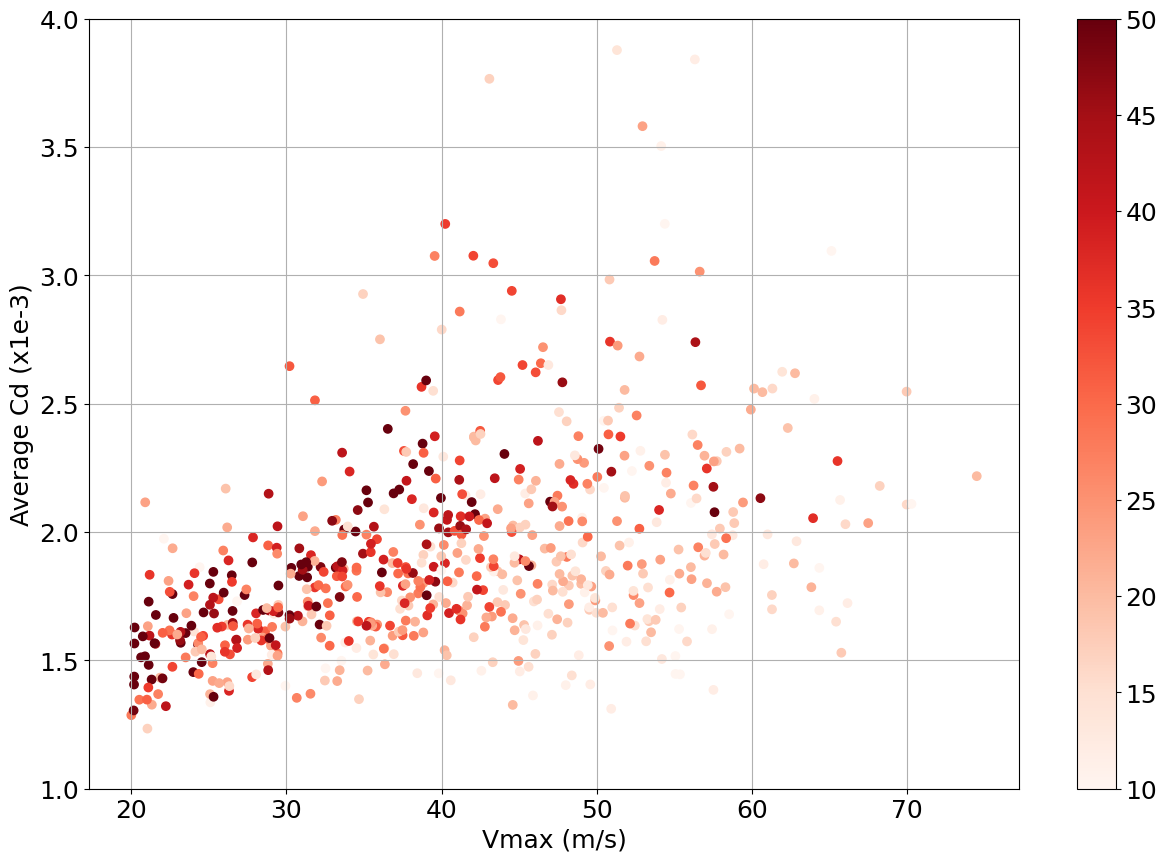

In [15]:
plt.scatter(new_dsg.vmx, new_dsg.cd_mean * 1e3, c=new_dsg.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()
plt.ylim(1, 4)
plt.grid()
plt.xlabel('Vmax (m/s)')
plt.ylabel('Average Cd (x1e-3)')

In [6]:
p  = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dk = xr.open_dataset(p)
dk = dk.where(
    (dk.lat > 0) &
    (dk.dist2coast > dk.r34)
)

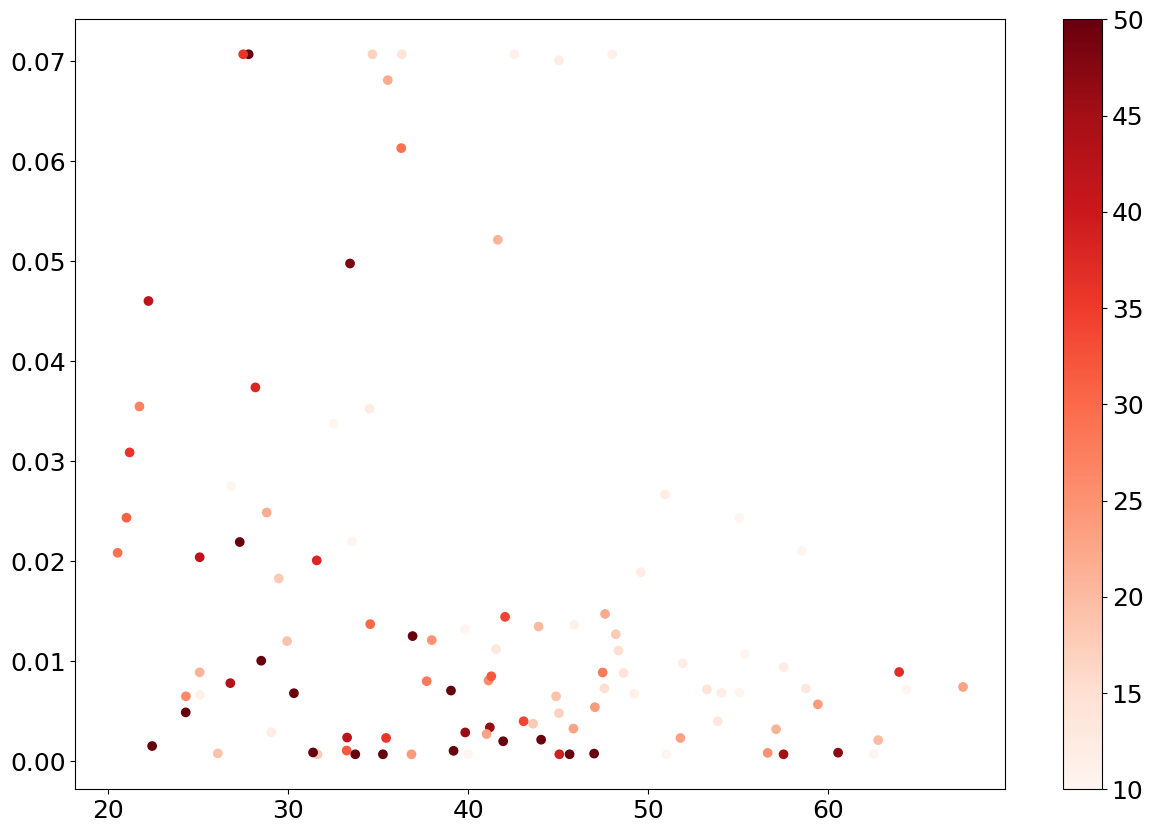

In [7]:
plt.scatter(dk.vmx, dk.C_K25, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()

In [8]:
drag = dk.C_K25 * np.sqrt(dk.c1_K25 ** 2 + dk.c2_K25 ** 2)

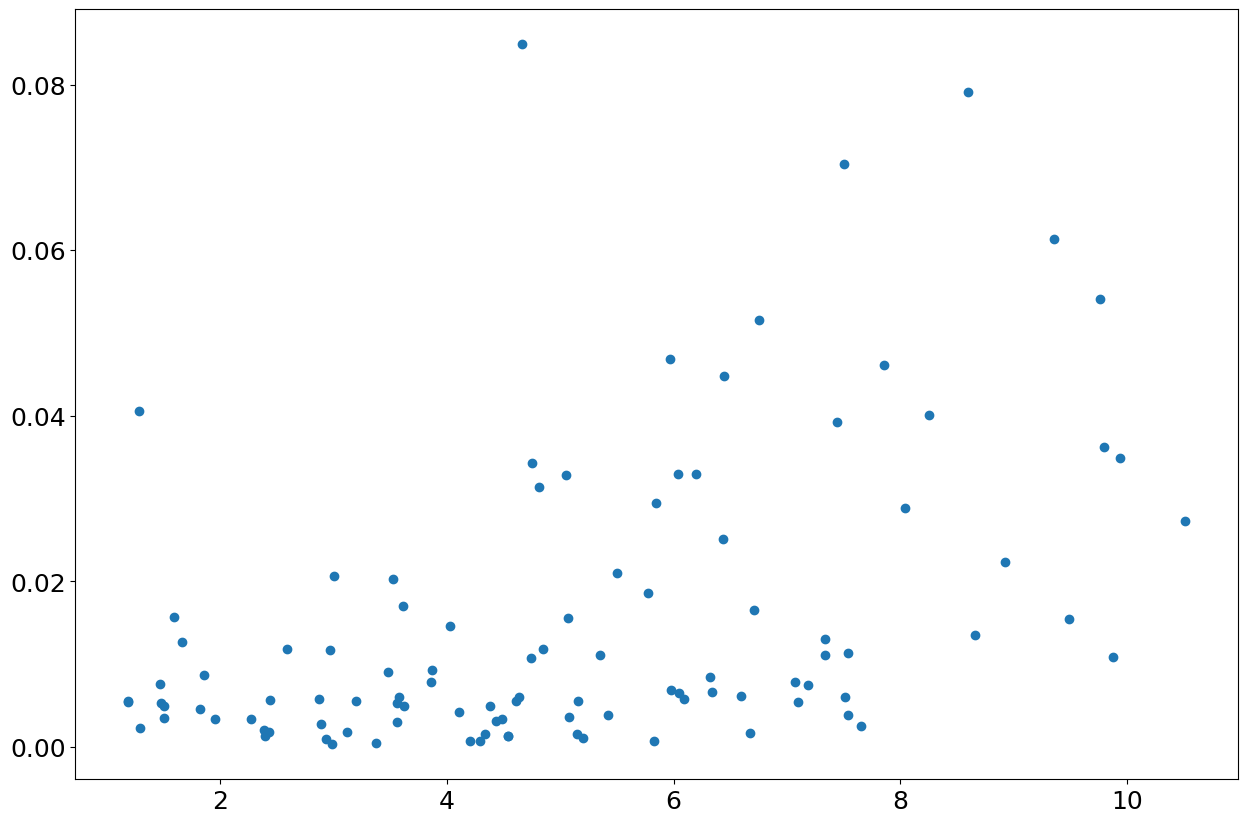

In [9]:
plt.scatter(dk.speed, drag)

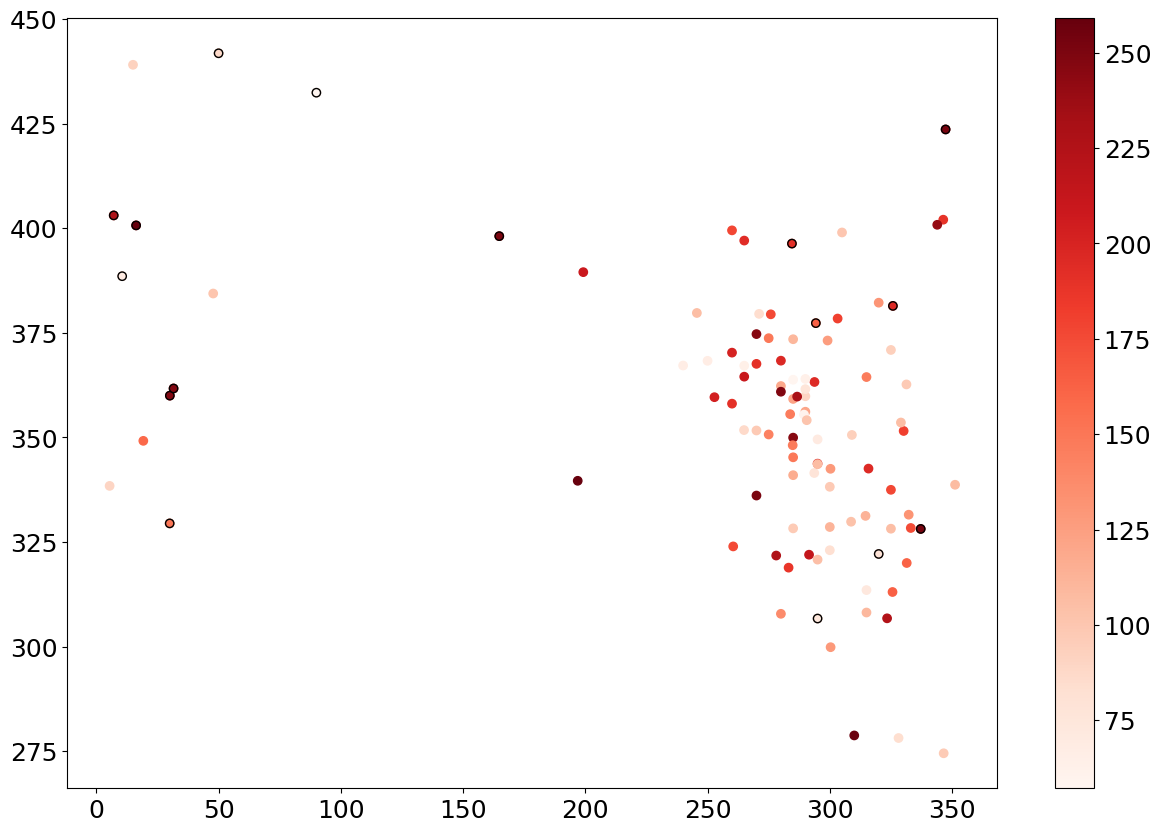

In [10]:
angles     = (np.rad2deg(np.arctan((dk.c1_K25 / dk.c2_K25))) % 360).copy(deep=True)
angles_bis = xr.where(angles >= 180, angles, angles + 360)
plt.scatter(dk.storm_dir_ibt, angles_bis, c=dk.wsd_pmd,                                                                   cmap=plt.get_cmap('Reds'))
plt.scatter(dk.storm_dir_ibt.where(dk.vws_pmd > 10), angles_bis.where(dk.vws_pmd > 10), c=dk.wsd_pmd.where(dk.vws_pmd > 10), cmap=plt.get_cmap('Reds'), edgecolors='k')
plt.colorbar()

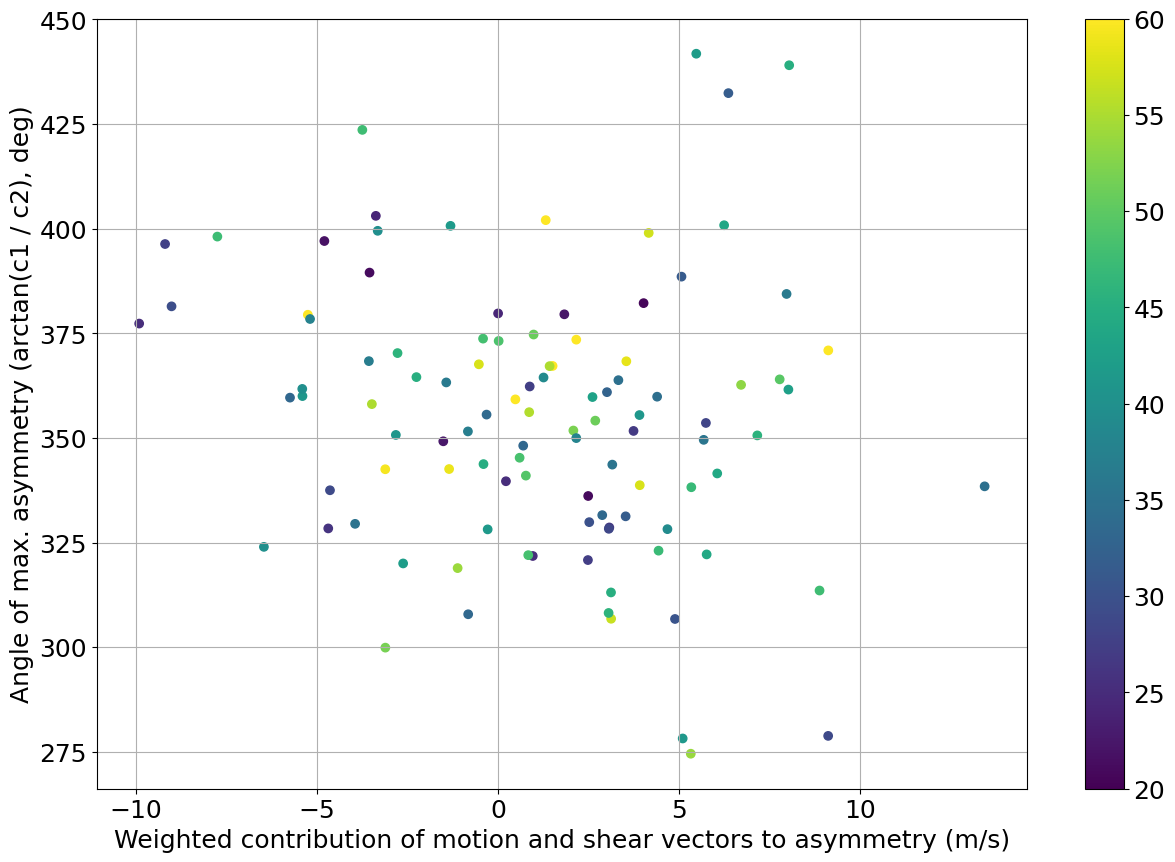

In [11]:
# c1 / c2 as a function of relative contribution from shear and motion vectors
# NB: les outliers en haut semblent normaux
# NB: l'outlier tout à gauche à un Vmax très faible, proche de 20 m/s
plt.scatter(dk.storm_speed_ibt * np.cos(np.deg2rad(dk.storm_dir_ibt)) + dk.vws_pmd * np.cos(np.deg2rad(dk.wsd_pmd)), angles_bis, c=dk.vmx, vmin=20, vmax=60)
plt.colorbar()
plt.xlabel('Weighted contribution of motion and shear vectors to asymmetry (m/s)')
plt.ylabel('Angle of max. asymmetry (arctan(c1 / c2), deg)')
plt.grid()

In [12]:
dk['wght_cont']  = dk.storm_speed_ibt * np.cos(np.deg2rad(dk.storm_dir_ibt)) + dk.vws_pmd * np.cos(np.deg2rad(dk.wsd_pmd))
dk['angles_bis'] = angles_bis

In [13]:
dk.where(dk.angles_bis > 425, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 3)> Size: 24B
array(['rs2--owi-ca-20191105t135113-20191105t135447-00003-______sw_io052019_cyclone_polar.nc',
       's1b-ew-owi-ca-20191106t194803-20191106t195007-000003-02377F_sw_wp242019_cyclone_polar.nc',
       'rcm2-sc50md-owi-ca-20210422t211644-20210422t212548-00003-______sw_wp022021_cyclone_polar.nc'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 24B 2019-11-05T13:53:00 ... 2021-04-22T21:...
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

In [14]:
dk.where(dk.wght_cont < -20, drop=True).file_tcva

<xarray.DataArray 'file_tcva' (time: 0)> Size: 0B
array([], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 0B 
Attributes:
    long_name:    File name in the TCVA database
    description:  Taken from Ifremer TCVA product

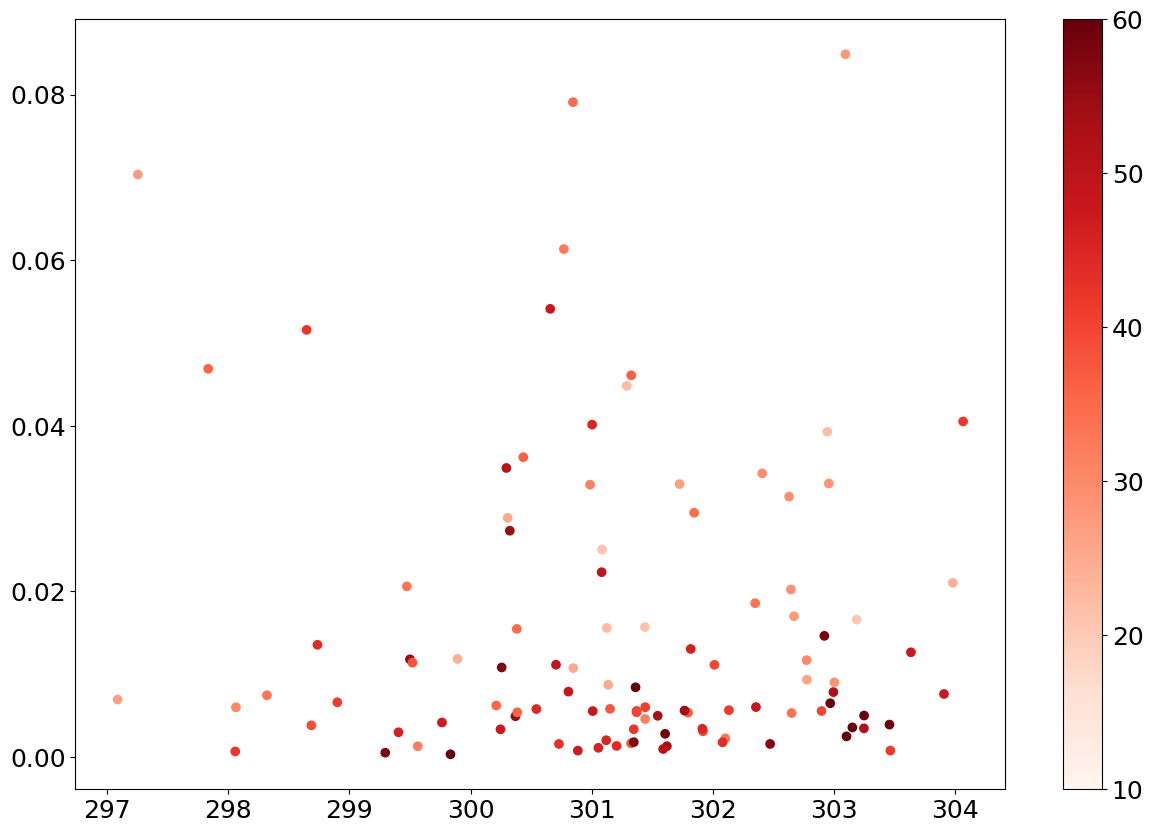

In [15]:
plt.scatter(dk.pre_sst_rms, drag, c=dk.vmx, vmin=10, vmax=60, cmap=plt.get_cmap('Reds'))
plt.colorbar()

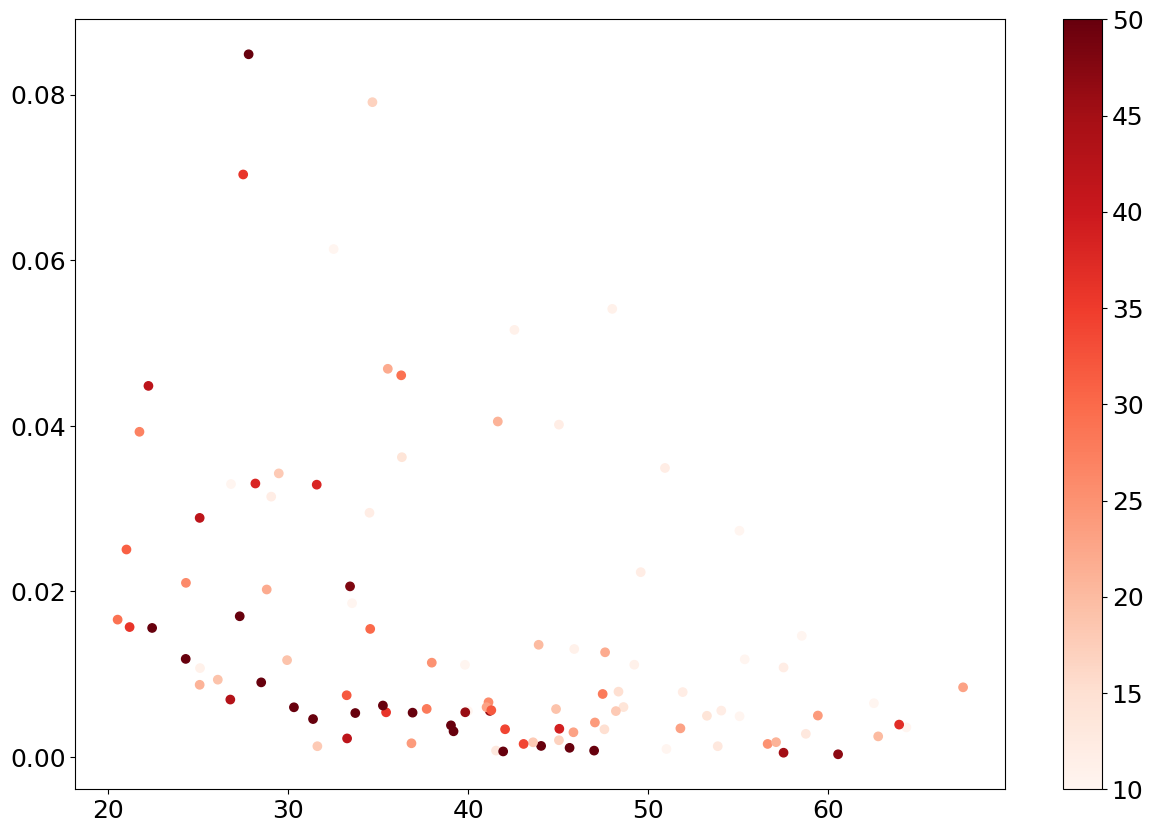

In [16]:
plt.scatter(dk.vmx, drag, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()

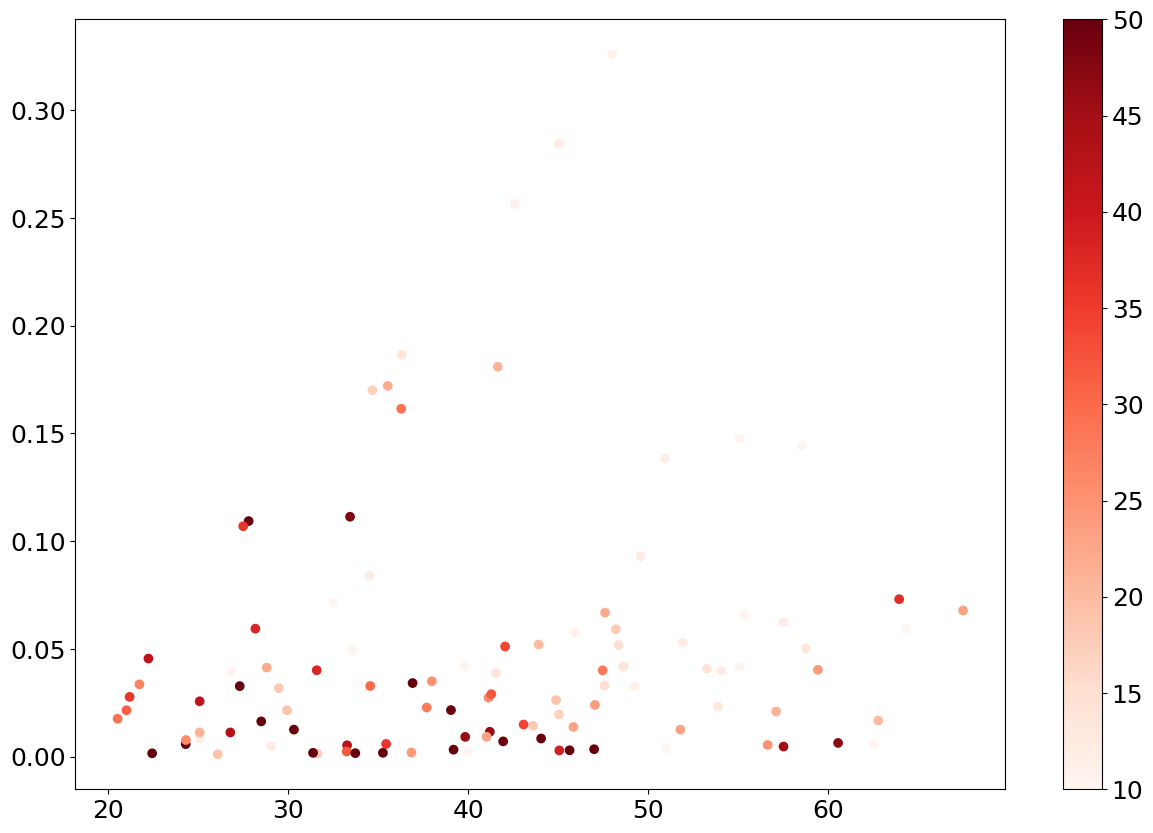

In [17]:
plt.scatter(dk.vmx, dk.C_sqrtK_K25 * (dk.vmx ** 2) / 10, c=dk.rmx / 1000, vmin=10, vmax=50, cmap=plt.get_cmap('Reds'))
plt.colorbar()